paths shape: (500, 10)
          5:5
        4:4
          5:6
      3:3
          5:8
        4:7
          5:9
    2:2
        4:11
      3:10
          5:13
        4:12
          5:14
  1:1
          5:18
        4:17
          5:19
      3:16
          5:21
        4:20
          5:22
    2:15
          5:25
        4:24
          5:26
      3:23
          5:28
        4:27
          5:29
0:0
          5:34
        4:33
          5:35
      3:32
          5:37
        4:36
          5:38
    2:31
          5:41
        4:40
          5:42
      3:39
          5:44
        4:43
          5:45
  1:30
          5:49
        4:48
          5:50
      3:47
          5:52
        4:51
          5:53
    2:46
          5:56
        4:55
          5:57
      3:54
          5:59
        4:58
          5:60
Classification Accuracy: 0.53
Precision: 0.41
Recall: 1.00
F1-Score: 0.58


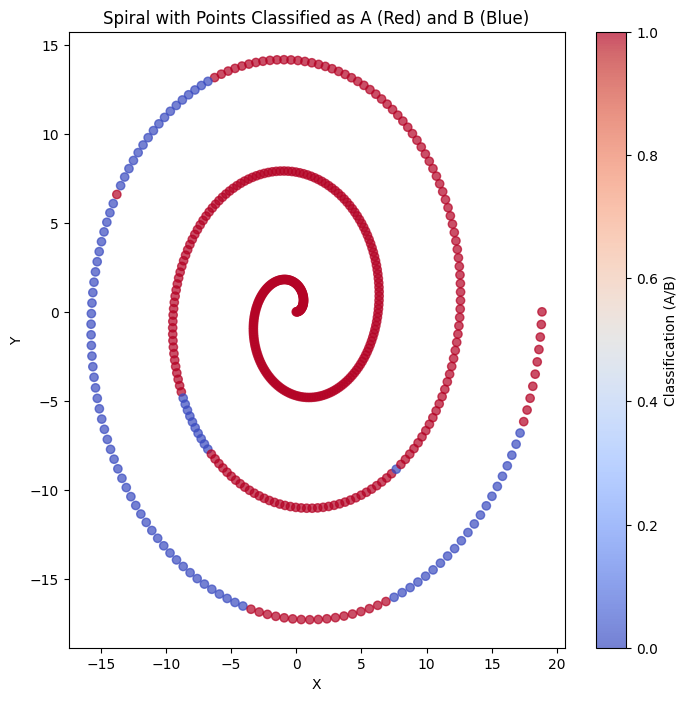

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomTreesEmbedding

def trace_binary_path(tree, sample_leaf_index):
    children_left = tree.children_left
    children_right = tree.children_right
    node = 0
    binary_path = ''
    search = sample_leaf_index
    while True:
        i = np.where(children_left == search)[0]
        if i.size:
            binary_path = '0' + binary_path
        else:
            i = np.where(children_right == search)[0]
            binary_path = '1' + binary_path
        i = i[0]
        if i == 0:
            break
        search = i
    return binary_path

def dist(x: str, y: str):
    depth = max(len(x), len(y))
    for i in range(depth):
        if x[i] != y[i]:
            return depth - i
    return 0

def children(tree):
    children_left = tree.children_left
    children_right = tree.children_right
    print(f'left: {list(enumerate(children_left))}')
    print(f'right: {list(enumerate(children_right))}')

def print_tree(tree, index = 0, offset = 0):
    if index == -1:
        return
    print_tree(tree, tree.children_left[index], offset + 1)
    print(' ' * (2 * offset) + f'{offset}:' + str(index))
    print_tree(tree, tree.children_right[index], offset + 1)

t = np.linspace(0, 6 * np.pi, 500)
x = t * np.cos(t)
y = t * np.sin(t)
points = np.vstack((x, y)).T

labels = np.where(t < 2 * np.pi, 'A', 'B')

random_trees = RandomTreesEmbedding(n_estimators=10, random_state=42)
encoded_points = random_trees.fit_transform(points).toarray()

binary_paths = []
for estimator in random_trees.estimators_:
    leaf_indices = estimator.apply(points).ravel()
    for leaf_index in leaf_indices:
        binary_path = trace_binary_path(estimator.tree_, leaf_index)
        binary_paths.append(binary_path)

binary_paths = np.array(binary_paths).reshape(len(random_trees.estimators_), len(points)).T
print(f'paths shape: {binary_paths.shape}')

print_tree(random_trees.estimators_[5].tree_)

num_points = len(points)
pairwise_distances = np.zeros((num_points, num_points))
for i in range(num_points):
    for j in range(i + 1, num_points):
        avg_distance = 0
        for k in range(len(random_trees.estimators_)):
            # print(i, j, k)
            try:
                avg_distance += dist(binary_paths[i][k], binary_paths[j][k])
            except IndexError as ie:
                print(ie, binary_paths[i][k], binary_paths[j][k])
                children(random_trees.estimators_[k].tree_)
                print(
                    random_trees.estimators_[k].apply([points[i], points[j]]),
                )
                raise IndexError(ie)
        avg_distance /= len(random_trees.estimators_)
        pairwise_distances[i, j] = avg_distance
        pairwise_distances[j, i] = avg_distance

predicted_labels = []
for i in range(num_points):
    distances_to_A = [pairwise_distances[i, j] for j in range(num_points) if labels[j] == 'A']
    distances_to_B = [pairwise_distances[i, j] for j in range(num_points) if labels[j] == 'B']
    if np.mean(distances_to_A) < np.mean(distances_to_B):
        predicted_labels.append('A')
    else:
        predicted_labels.append('B')

accuracy = np.mean(np.array(predicted_labels) == labels)
print(f"Classification Accuracy: {accuracy:.2f}")

from sklearn.metrics import precision_score, recall_score, f1_score

true_labels = np.array([1 if label == 'A' else 0 for label in labels])
predicted_labels_binary = np.array([1 if label == 'A' else 0 for label in predicted_labels])
precision = precision_score(true_labels, predicted_labels_binary, pos_label=1)
recall = recall_score(true_labels, predicted_labels_binary, pos_label=1)
f1 = f1_score(true_labels, predicted_labels_binary, pos_label=1)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

plt.figure(figsize=(8, 8))
plt.scatter(x, y, c=[1 if label == 'A' else 0 for label in predicted_labels], cmap='coolwarm', alpha=0.7)
plt.title("Spiral with Points Classified as A (Red) and B (Blue)")
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(label="Classification (A/B)")
plt.show()

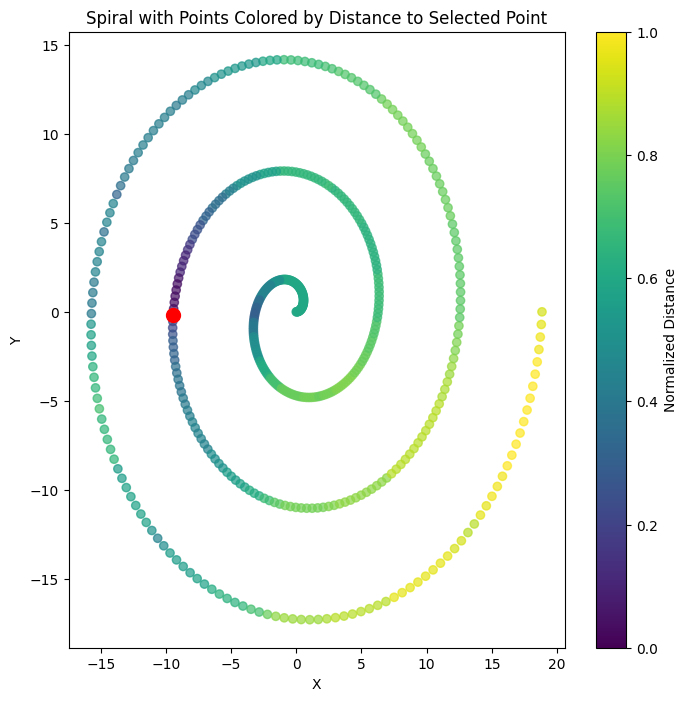

In [ ]:
def color_points_by_pairwise_distance(pairwise_distances, selected_point_index):
    distances = pairwise_distances[selected_point_index]
    colors = distances / np.max(distances)
    return colors


selected_point_index = 250

colors = color_points_by_pairwise_distance(pairwise_distances, selected_point_index)

plt.figure(figsize=(8, 8))
plt.scatter(x, y, c=colors, cmap='viridis', alpha=0.7)
plt.scatter([x[selected_point_index]], [y[selected_point_index]], c='red', s=100)
plt.title("Spiral with Points Colored by Distance to Selected Point")
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(label="Normalized Distance")
plt.show()

KNN Score:  1.0
Classification Accuracy: 1.00


C:\Users\Максим\AppData\Local\Temp\ipykernel_28924\444216521.py:31: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x[test_idx], y[test_idx], c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")


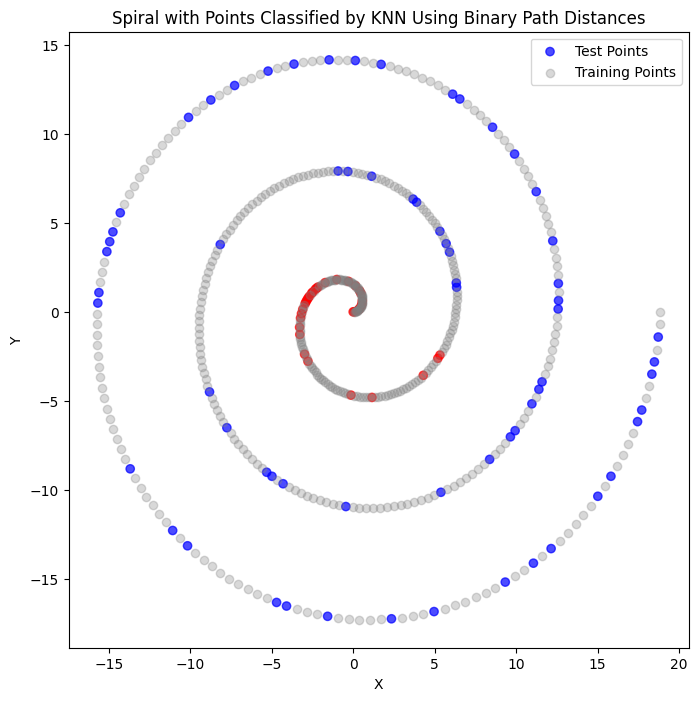

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split





train_idx, test_idx = train_test_split(np.arange(num_points), test_size=0.2, random_state=42)
D = pairwise_distances[:, train_idx]
train_distances = D[train_idx] 
test_distances = D[test_idx] 
train_labels = labels[train_idx]
test_labels = labels[test_idx]

knn = KNeighborsClassifier(n_neighbors=5, metric='precomputed')
knn.fit(train_distances, train_labels)

print('KNN Score: ', knn.score(test_distances, test_labels))

predicted_labels = knn.predict(test_distances)

accuracy = accuracy_score(test_labels, predicted_labels)
print(f"Classification Accuracy: {accuracy:.2f}")

plt.figure(figsize=(8, 8))
colors = ['red' if label == 'A' else 'blue' for label in predicted_labels]
plt.scatter(x[test_idx], y[test_idx], c=colors, cmap='coolwarm', alpha=0.7, label="Test Points")
plt.scatter(x[train_idx], y[train_idx], c='gray', alpha=0.3, label="Training Points")
plt.title("Spiral with Points Classified by KNN Using Binary Path Distances")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()